# Cars price

## Data preparation

### Libraries

In [1]:
# !pip install fast_ml
# !pip install lightgbm 

In [2]:
import pandas as pd
import numpy as np
import math

from datetime import datetime

from scipy.spatial.distance import pdist, squareform

from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import phik
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

import warnings

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [3]:
state = 42

### Data

In [4]:
try:
    data = pd.read_csv(r'C:\Users\olga.poletkina\OneDrive - HPP Architekten GmbH\GitHub\Practicum_Data_Science\datasets\autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')
    
data_initial = data.copy()

### Data analysis

In [5]:
separation_line = '------------------------------------------------------------------------------------------------------'

def data_check(df):
    df.info()
    print(separation_line)
    print('Comtlete duplicates = ', df.duplicated().sum())
    print(separation_line)
    print('NaNs by columns:')
    display(df.isna().sum())
    print(separation_line)
    print('Total NaNs:')
    display(df.isna().sum().sum())
    print(separation_line)
    display(df.describe())
    print(separation_line)
    print('Data types:')
    display(df.columns.to_series().groupby(df.dtypes).groups)

In [6]:
data_check(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

------------------------------------------------------------------------------------------------------
Total NaNs:


181077

------------------------------------------------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


------------------------------------------------------------------------------------------------------
Data types:


{int64: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode'], object: ['DateCrawled', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'LastSeen']}

In [7]:
data = data.drop_duplicates()

In [8]:
def add_underscore(name):
    new_name = ''
    for i, char in enumerate(name):
        if i > 0 and char.isupper() and name[i-1].islower():
            new_name += '_'
        new_name += char
    return new_name

new_columns = {col: add_underscore(col) for col in data.columns}
data = data.rename(columns=new_columns)
data.columns = data.columns.str.strip().str.lower()
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Features distribution, missing values.

**Remove the column 'number_of_pictures' that contains only zeros**

In [9]:
data['number_of_pictures'].unique()

array([0], dtype=int64)

In [10]:
data = data.drop(columns=['number_of_pictures'])

In [11]:
data = data.drop(columns=['postal_code', 'last_seen', 'date_crawled', 'date_created'])

In [12]:
data.columns.to_series().groupby(data.dtypes).groups

{int64: ['price', 'registration_year', 'power', 'kilometer', 'registration_month'], object: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']}

**Features correlation**

In [13]:
columns_info = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 
                'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

data[columns_info].head()

,price,registration_year,power,kilometer,registration_month,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,480,1993,0,150000,0,NaN,manual,golf,petrol,volkswagen,NaN
1,18300,2011,190,125000,5,coupe,manual,NaN,gasoline,audi,yes
2,9800,2004,163,125000,8,suv,auto,grand,gasoline,jeep,NaN
3,1500,2001,75,150000,6,small,manual,golf,petrol,volkswagen,no
4,3600,2008,69,90000,7,small,manual,fabia,gasoline,skoda,no


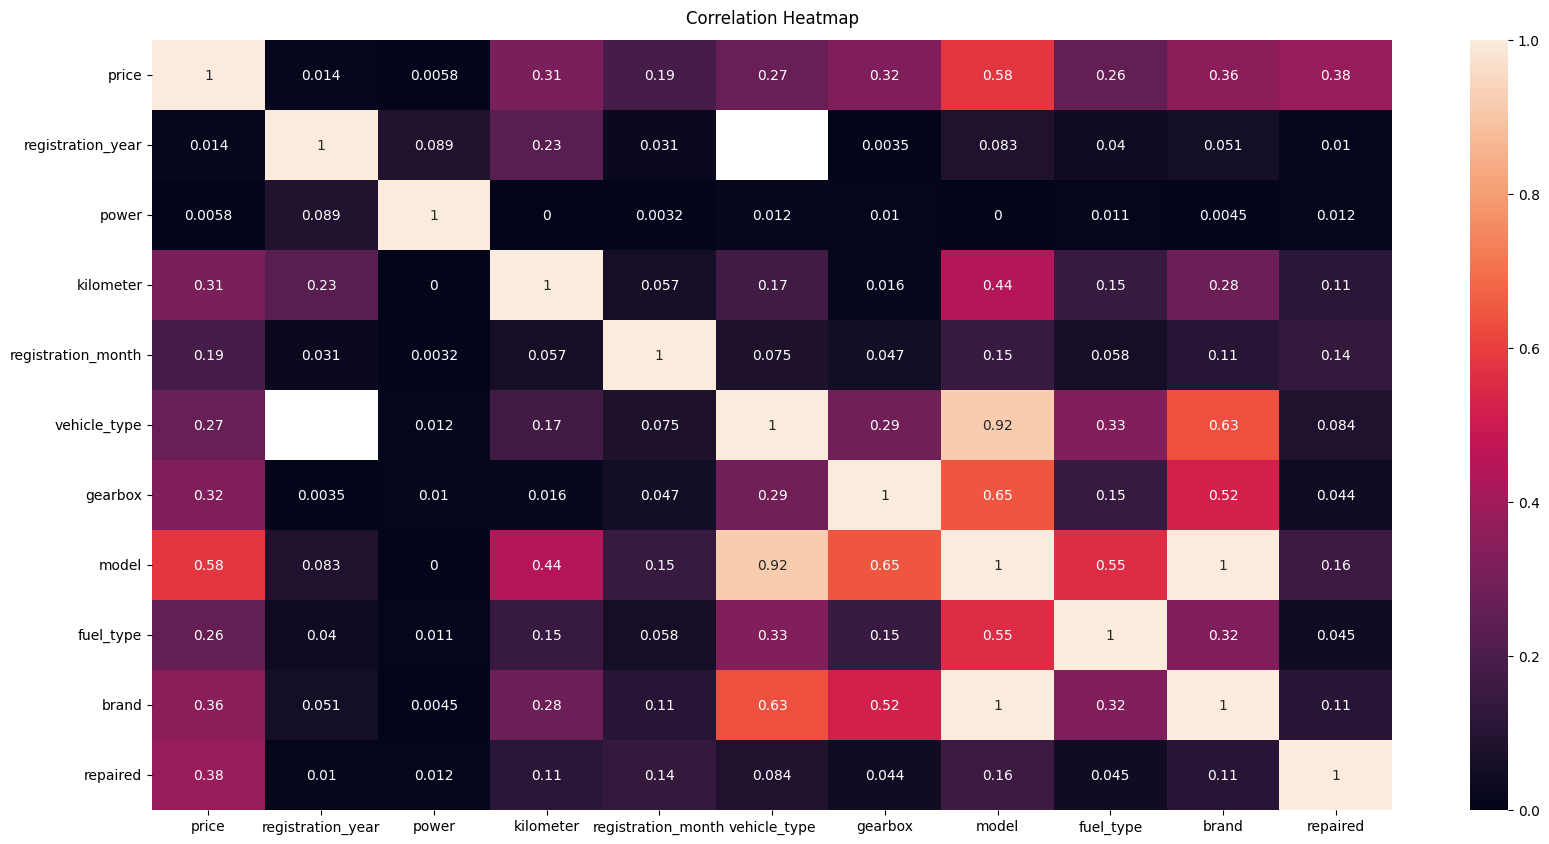

In [14]:
warnings.filterwarnings("ignore")

interval_columns = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']

plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(data[columns_info].phik_matrix(interval_cols=interval_columns), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12}, pad=12)

plt.show()

**Matches in columns for missing values**

In [15]:
data[columns_info].isna()
data[columns_info].isna().T
pdist(data[columns_info].isna().T, metric = lambda x, y: (x & y).sum())

array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        9970.,  6828., 17295.,     0., 20571.,  4131.,  8920.,     0.,
       12788.,  7163.,     0.,  9054.,     0., 16581.,     0.])

In [16]:
def highlight(val):
    color = 'red' if val >= 0.7 else 'black'
    return 'color: %s' % color

In [17]:
warnings.filterwarnings("ignore")

pd.DataFrame(
    squareform(pdist(data[columns_info].isna().T, metric = lambda x, y: (x & y).sum() / (x | y).sum())),
    index = data[columns_info].columns,
    columns = data[columns_info].columns
).style.applymap(highlight).format("{:,.2f}")

,price,registration_year,power,kilometer,registration_month,vehicle_type,gearbox,model,fuel_type,brand,repaired
price,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,nan,0.00
registration_year,nan,0.00,nan,nan,nan,0.00,0.00,0.00,0.00,nan,0.00
power,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,0.00
kilometer,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,0.00
registration_month,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,nan,0.00
vehicle_type,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.14,0.33,0.00,0.23
gearbox,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.12,0.20,0.00,0.16
model,0.00,0.00,0.00,0.00,0.00,0.14,0.12,0.00,0.16,0.00,0.11
fuel_type,0.00,0.00,0.00,0.00,0.00,0.33,0.20,0.16,0.00,0.00,0.19
brand,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00


**Features distribution**

In [18]:
categorical_data_ = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'registration_month']
numerical_data = ['price', 'registration_year', 'power', 'kilometer']

price


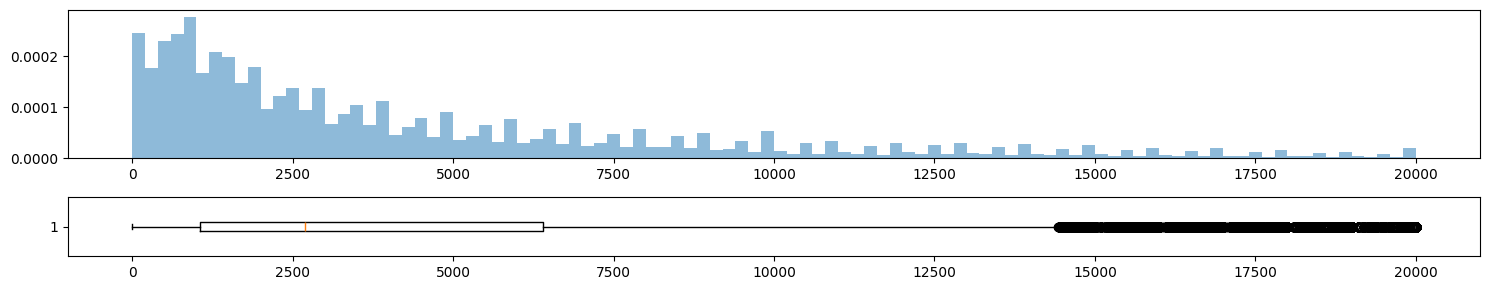

registration_year


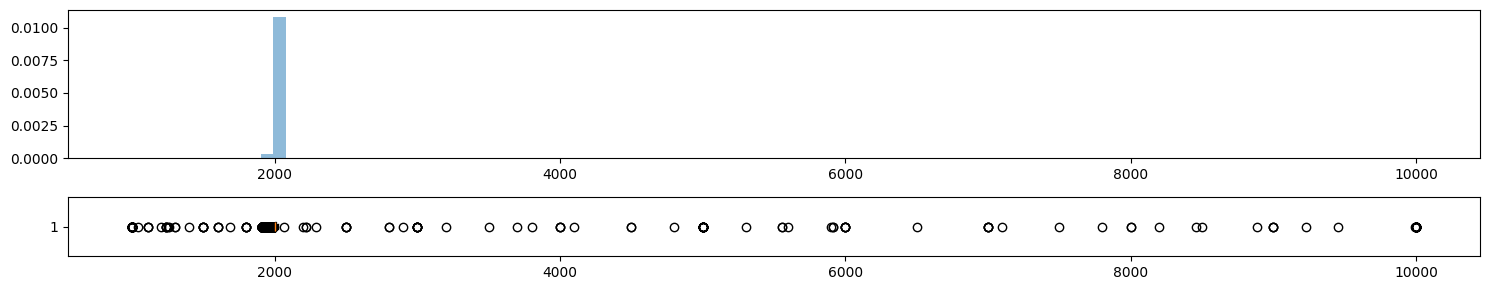

power


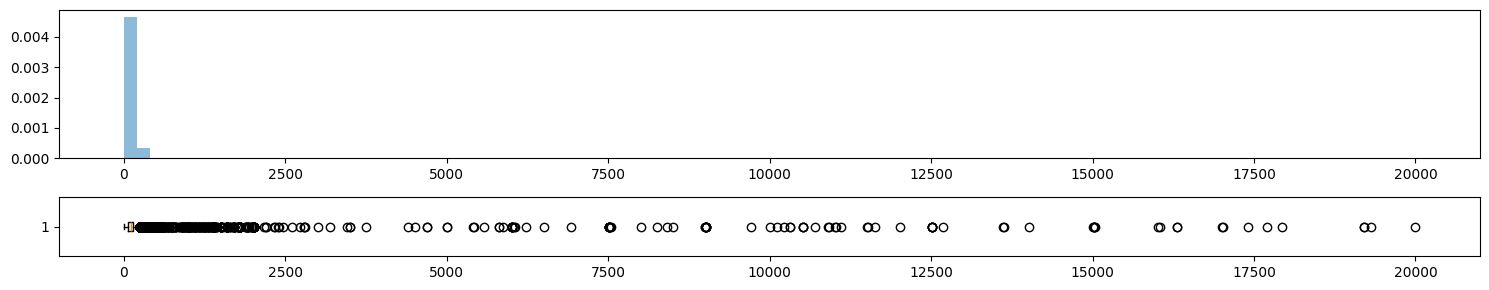

kilometer


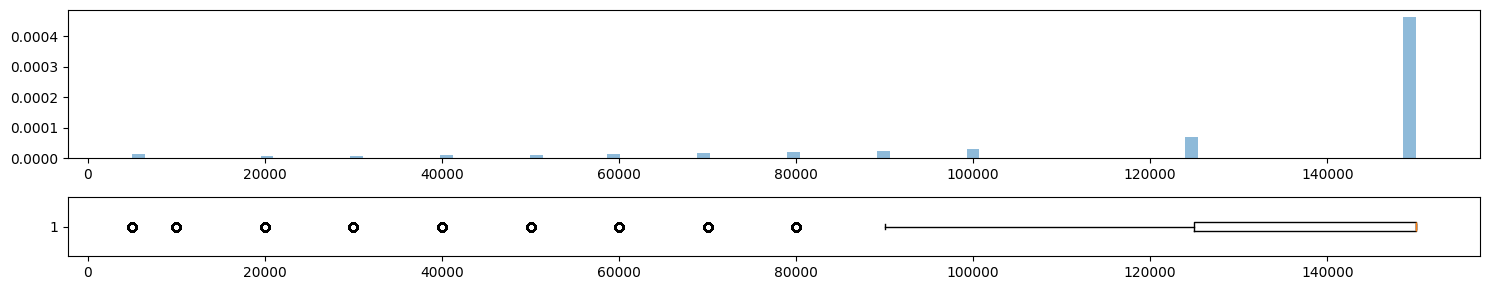

In [19]:
for column in data[numerical_data].columns:
    print(column)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [5, 2]}, figsize=(15, 3))
    ax1.hist(data[column], bins=100, alpha=0.5, density=True)
    ax2.boxplot(data[column], vert=False)
    ax2.set_xlim(ax1.get_xlim())
    plt.tight_layout()
    plt.show()

vehicle_type


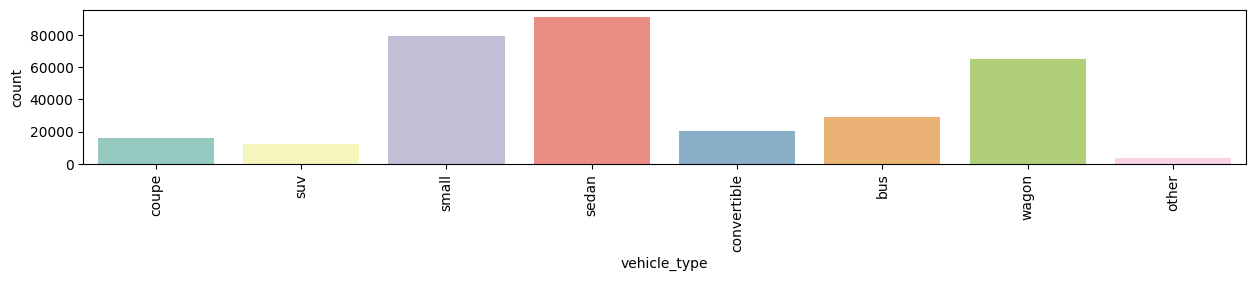

gearbox


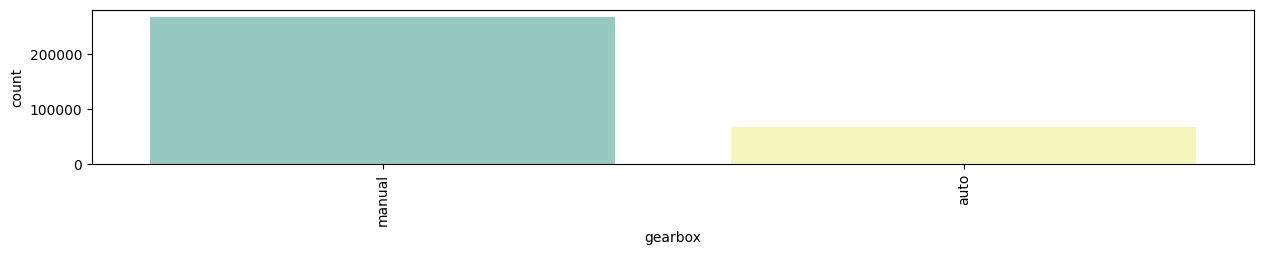

fuel_type


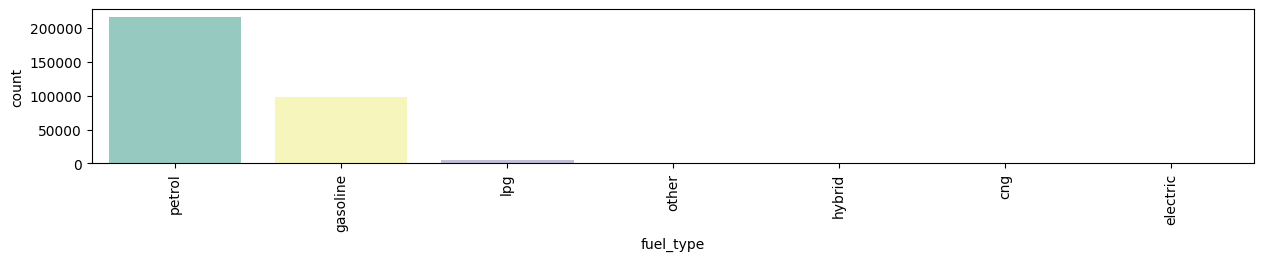

brand


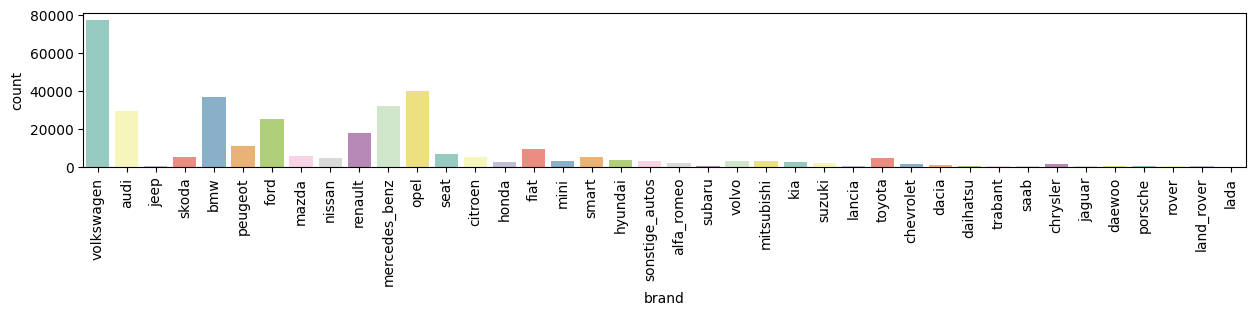

repaired


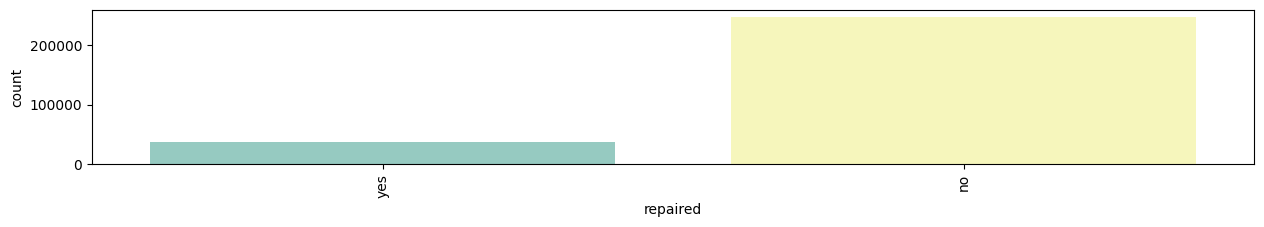

registration_month


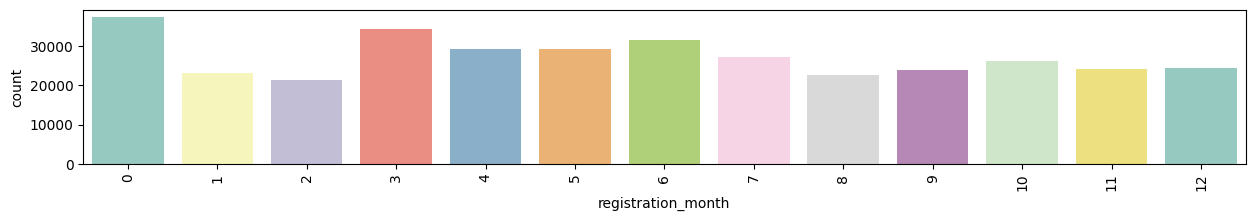

In [20]:
for column in data[categorical_data_].columns:
    print(column)
    fig, ax = plt.subplots(figsize=(15, 2))
    sns.countplot(x=column, data=data, ax=ax, palette='Set3')
    plt.xticks(rotation=90)
    plt.show()

**Closer look at 'registration_year' and 'power'**

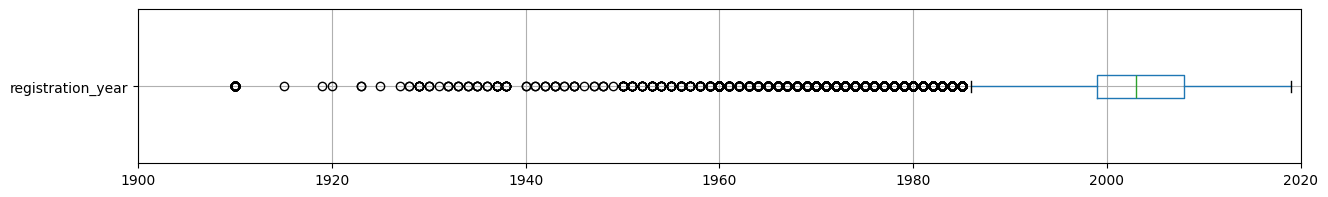

In [21]:
data[['registration_year']].boxplot(vert=False, figsize=(15, 2))
plt.xlim(1900, 2020)
plt.show()

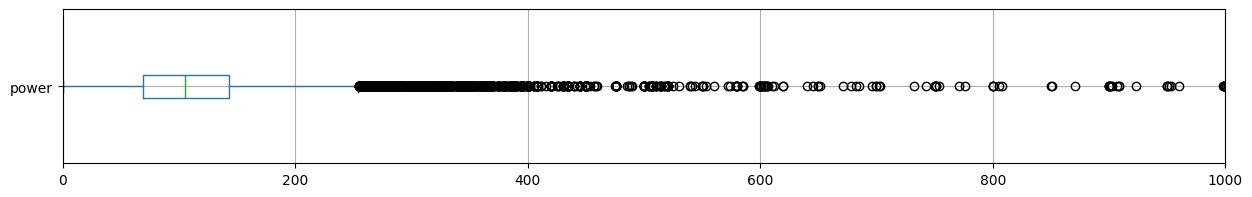

In [22]:
data[['power']].boxplot(vert=False, figsize=(15, 2))
plt.xlim(0, 1000)
plt.show()

First and foremost, we should pay attention to the 'registration_year' and 'power' plots. They seem to contain unusual or incorrect data points (outliers), such as a car's power rating being equal to 0 or exceeding 500-700 horsepower, or registration years later than 2016.

In [23]:
print('The data with car power ratings exceeding 600 horsepower make up approximately {} %'.format(round(
    len(data[data['power'] > 600]) / len(data) * 100, 2)))

The data with car power ratings exceeding 600 horsepower make up approximately 0.11 %


In [24]:
print('The data with car power ratings equal to 0 make up approximately {} %'.format(round(
    len(data[data['power'] == 0]) / len(data) * 100, 2)))

The data with car power ratings equal to 0 make up approximately 11.35 %


There are too many data points with zero power ratings, so we won't remove them

In [25]:
print('The data with registration years later than 2016 make up approximately {} %'.format(round(
    len(data[data['registration_year'] > 2016]) / len(data) * 100, 2)))

The data with registration years later than 2016 make up approximately 4.1 %


In [26]:
print('The data with registration years earlier than 1970 make up approximately {} %'.format(round(
    len(data[data['registration_year'] < 1970]) / len(data) * 100, 2)))

The data with registration years earlier than 1970 make up approximately 0.38 %


**Removing outliers in the 'power' and 'registration_year' columns**

In [27]:
len(data)

354365

In [28]:
# data = data.loc[data['power'] > 600]
data = data.drop(data[data['power'] > 600].index).reset_index(drop=True)

In [29]:
data = data.drop(data[data['registration_year'] > 2016].index).reset_index(drop=True)

In [30]:
data = data.drop(data[data['registration_year'] < 1970].index).reset_index(drop=True)

In [31]:
print('The data with a price equal to 0 make up approximately {} %'.format(round(
    len(data[data['price'] == 0]) / len(data) * 100, 2)))

The data with a price equal to 0 make up approximately 2.91 %


**Removing outliers in 'price'**

In [32]:
data = data.drop(data[data['price'] == 0].index).reset_index(drop=True)

During the process of handling missing values after splitting into subsets, it was discovered that the 'brand' column contains missing values filled with the string 'sonstige_autos,' which corresponds to rows with NaN values in the 'model' column. Consequently, these entries lack both brand and model information, and it was decided to remove the rows with this data from the overall dataset.

In [33]:
print('The data with "sonstige_autos" in the table make up approximately {} %'.format(round(
    len(data[data['brand'] == 'sonstige_autos']) / len(data) * 100, 2)))

The data with "sonstige_autos" in the table make up approximately 0.73 %


In [34]:
data = data.drop(data[data['brand'] == 'sonstige_autos'].index).reset_index(drop=True)

In [35]:
print('Overall, {}% of the data was removed'.format(round(100 - len(data)/ len(data_initial) *100, 2)))

Overall, 8.03% of the data was removed


In [36]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325905 entries, 0 to 325904
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               325905 non-null  int64 
 1   vehicle_type        306599 non-null  object
 2   registration_year   325905 non-null  int64 
 3   gearbox             311125 non-null  object
 4   power               325905 non-null  int64 
 5   model               313081 non-null  object
 6   kilometer           325905 non-null  int64 
 7   registration_month  325905 non-null  int64 
 8   fuel_type           302593 non-null  object
 9   brand               325905 non-null  object
 10  repaired            267245 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


### Splitting the data into training, validation, and test sets

In [38]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'price',
                                                                           train_size=0.6, valid_size=0.2, test_size=0.2, 
                                                                           random_state=state)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(195543, 10)
(65181, 10)
(65181, 10)
(195543,)
(65181,)
(65181,)


### Filling missing values in the training dataset

**Filling the missing values in the 'model' column with the mode of the 'brand' column**

In [39]:
mapping_dict = X_train.groupby('brand')['model'].agg(lambda x: x.mode()[0]).to_dict()
# mapping_dict

In [40]:
X_train['model'] = X_train['model'].fillna(data['brand'].map(mapping_dict))
X_valid['model'] = X_valid['model'].fillna(data['brand'].map(mapping_dict))
X_test['model'] = X_test['model'].fillna(data['brand'].map(mapping_dict))

In [41]:
print(X_train['model'].isna().sum())
print(X_valid['model'].isna().sum())
print(X_test['model'].isna().sum())

0
0
0


**Filling the missing values in the 'vehicle_type' column with the mode of the 'model' column**

When 'model' has the value 'unknown,' we also fill 'vehicle_type' with the value 'unknown'

In [42]:
mapping_dict_2 = X_train.groupby('model')['vehicle_type'].agg(
    lambda x: x.mode()[0] if len(x.mode())> 0 else 'unknown').to_dict()
# mapping_dict_2

In [43]:
X_train['vehicle_type'] = X_train['vehicle_type'].fillna(X_train['model'].map(mapping_dict_2))
X_valid['vehicle_type'] = X_valid['vehicle_type'].fillna(X_valid['model'].map(mapping_dict_2))
X_test['vehicle_type'] = X_test['vehicle_type'].fillna(X_test['model'].map(mapping_dict_2))

In [44]:
print(X_train['vehicle_type'].isna().sum())
print(X_valid['vehicle_type'].isna().sum())
print(X_test['vehicle_type'].isna().sum())

0
0
0


**The remaining missing values are filled with 'unknown'**

In [45]:
X_train['repaired'] = X_train['repaired'].fillna('unknown')
X_valid['repaired'] = X_valid['repaired'].fillna('unknown')
X_test['repaired'] = X_test['repaired'].fillna('unknown')

The 'repaired' column is challenging to fill using statistical methods, so it makes more sense to set the status as 'unknown'. In the case of the remaining columns, 'gearbox' and 'fuel_type,' there is some correlation with fully filled columns, but they are not close to high values. Therefore, the decision was made to fill them with 'unknown' as well

In [46]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [47]:
X_train['gearbox'] = X_train['gearbox'].fillna('unknown')
X_valid['gearbox'] = X_valid['gearbox'].fillna('unknown')
X_test['gearbox'] = X_test['gearbox'].fillna('unknown')

In [48]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [49]:
X_train['fuel_type'] = X_train['fuel_type'].fillna('other')
X_valid['fuel_type'] = X_valid['fuel_type'].fillna('other')
X_test['fuel_type'] = X_test['fuel_type'].fillna('other')

In [50]:
print('NaNs in X_train =', X_train.isna().sum().sum())
print('NaNs in X_valid =', X_valid.isna().sum().sum())
print('NaNs in X_test =',X_test.isna().sum().sum())

NaNs in X_train = 0
NaNs in X_valid = 0
NaNs in X_test = 0


**Results of the data analysis and processing:**

- Missing values were detected in the following columns:
  - 'VehicleType'
  - 'Gearbox'
  - 'Model'
  - 'FuelType'
  - 'Repaired'

- All column names were converted to lowercase with underscores.

- The following columns were deleted as they are not relevant for model building:
  - 'postal_code'
  - 'last_seen'
  - 'date_crawled'
  - 'date_created'

- 'number_of_pictures' was also removed as it had no data.

- High correlation was found between the following columns:
  - 'brand' and 'model'
  - 'model' and 'vehicle_type'
  Missing values in these columns were filled with the mode.

- In the 'brand' column, there were missing values filled with the string 'sonstige_autos,' which corresponds to NaN values in the 'model' column. Consequently, rows with no brand or model information were removed from the overall dataset.

- Outliers were identified in the following columns:
  - 'registration_year'
  - 'power'
  These outliers included unusual or incorrect data, such as cars with power ratings of 0 or exceeding 500-700 horsepower, or registration years earlier than 1970 or later than 2016. These outliers were removed.

- The 'repaired' column was challenging to fill using statistical methods, so missing values were replaced with 'unknown.'

- The 'gearbox' and 'fuel_type' columns were filled with 'other' and 'unknown' values.


## Models

### CatboostRegressor_1

In [51]:
X_train.columns.to_series().groupby(X_train.dtypes).groups

{int64: ['registration_year', 'power', 'kilometer', 'registration_month'], object: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']}

In [52]:
categorical_data = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'registration_month']

In [53]:
parameters_cbr = {'cat_features': categorical_data,
                  'eval_metric': 'RMSE',
                  'random_seed': state,
                  'verbose':100}

In [54]:
model_cbr = CatBoostRegressor(**parameters_cbr)

In [55]:
%%time

model_cbr.fit(X_train,y_train,eval_set=(X_valid,y_valid))

Learning rate set to 0.116579
0:	learn: 4185.9047111	test: 4195.3531858	best: 4195.3531858 (0)	total: 287ms	remaining: 4m 46s
100:	learn: 1719.5328079	test: 1742.1366897	best: 1742.1366897 (100)	total: 14.3s	remaining: 2m 7s
200:	learn: 1641.3988860	test: 1676.5558081	best: 1676.5558081 (200)	total: 28.2s	remaining: 1m 52s
300:	learn: 1606.9029796	test: 1651.9738491	best: 1651.9738491 (300)	total: 41.7s	remaining: 1m 36s
400:	learn: 1580.5706792	test: 1636.1638702	best: 1636.1638702 (400)	total: 55.8s	remaining: 1m 23s
500:	learn: 1560.4809410	test: 1624.5786315	best: 1624.5786315 (500)	total: 1m 10s	remaining: 1m 10s
600:	learn: 1543.5774180	test: 1614.6283571	best: 1614.6283571 (600)	total: 1m 25s	remaining: 56.7s
700:	learn: 1530.3477282	test: 1608.4987413	best: 1608.4987413 (700)	total: 1m 39s	remaining: 42.6s
800:	learn: 1518.6172214	test: 1602.5792985	best: 1602.5792985 (800)	total: 1m 54s	remaining: 28.4s
900:	learn: 1507.4853681	test: 1597.8569003	best: 1597.8555188 (899)	total

In [56]:
model_cbr.get_feature_importance(prettified=True)

,Feature Id,Importances
0,registration_year,38.410619
1,power,25.118895
2,kilometer,11.037921
3,brand,8.131909
4,vehicle_type,5.443442
5,model,4.318418
6,repaired,3.109666
7,fuel_type,2.871862
8,gearbox,1.033426
9,registration_month,0.523844


In [57]:
%%time

predictions_catboost = model_cbr.predict(X_valid)
rse_catboost = mean_squared_error(y_valid, predictions_catboost, squared=False) 
print('RMSE =', rse_catboost)

RMSE = 1593.1445257678683
CPU times: total: 1.31 s
Wall time: 386 ms


### CatboostRegressor_2

In [58]:
parameters_cbr_2 = {'cat_features': categorical_data,
                        'eval_metric': 'RMSE',
                        'random_seed': state,
                        'learning_rate': 0.8,
                        'verbose':100}

In [59]:
model_cbr_2 = CatBoostRegressor(**parameters_cbr_2)

In [60]:
%%time

model_cbr_2.fit(X_train,y_train,eval_set=(X_valid,y_valid))

0:	learn: 2741.1995795	test: 2746.6675698	best: 2746.6675698 (0)	total: 155ms	remaining: 2m 34s
100:	learn: 1590.4998341	test: 1663.0031405	best: 1662.8338502 (98)	total: 14.3s	remaining: 2m 7s
200:	learn: 1524.3723545	test: 1642.6821798	best: 1642.4244558 (196)	total: 28.9s	remaining: 1m 55s
300:	learn: 1483.3413470	test: 1632.7984116	best: 1632.5495348 (291)	total: 44.1s	remaining: 1m 42s
400:	learn: 1448.7667408	test: 1628.3096424	best: 1627.9640469 (394)	total: 60s	remaining: 1m 29s
500:	learn: 1423.2838354	test: 1625.1479246	best: 1624.5401136 (496)	total: 1m 15s	remaining: 1m 15s
600:	learn: 1401.7273815	test: 1625.3628962	best: 1623.5937138 (559)	total: 1m 33s	remaining: 1m 2s
700:	learn: 1382.2937345	test: 1624.4724870	best: 1623.5937138 (559)	total: 1m 51s	remaining: 47.5s
800:	learn: 1364.9759213	test: 1623.5190267	best: 1623.4846943 (792)	total: 2m 7s	remaining: 31.7s
900:	learn: 1349.7446872	test: 1622.2999356	best: 1622.0624772 (844)	total: 2m 24s	remaining: 15.9s
999:	lea

In [61]:
%%time

predictions_catboost_2 = model_cbr_2.predict(X_valid)
rse_catboost_2 = mean_squared_error(y_valid, predictions_catboost_2, squared=False) 
print('RMSE =', rse_catboost_2)

RMSE = 1621.130282538108
CPU times: total: 1.73 s
Wall time: 454 ms


### lightgbm.LGBMRegressor_1

In [62]:
categorical_data = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'registration_month']

for col in categorical_data:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    X_test[col] = X_test[col].astype('category')
        
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195543 entries, 201268 to 121958
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        195543 non-null  category
 1   registration_year   195543 non-null  int64   
 2   gearbox             195543 non-null  category
 3   power               195543 non-null  int64   
 4   model               195543 non-null  category
 5   kilometer           195543 non-null  int64   
 6   registration_month  195543 non-null  category
 7   fuel_type           195543 non-null  category
 8   brand               195543 non-null  category
 9   repaired            195543 non-null  category
dtypes: category(7), int64(3)
memory usage: 7.5 MB


In [63]:
%%time

model_lgb_noparam = LGBMRegressor(categorical_feature=categorical_data)
model_lgb_noparam.fit(X_train, y_train)

[LightGBM] [Warning] categorical_feature is set=vehicle_type,gearbox,model,fuel_type,brand,repaired,registration_month, categorical_column=0,2,4,6,7,8,9 will be ignored. Current value: categorical_feature=vehicle_type,gearbox,model,fuel_type,brand,repaired,registration_month
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 195543, number of used features: 10
[LightGBM] [Info] Start training from score 4588.531116
CPU times: total: 3.67 s
Wall time: 1.03 s


LGBMRegressor(categorical_feature=['vehicle_type', 'gearbox', 'model',
                                   'fuel_type', 'brand', 'repaired',
                                   'registration_month'])

In [64]:
%%time

predictions_lgb = model_lgb_noparam.predict(X_valid)
rse_lgb = mean_squared_error(y_valid, predictions_lgb, squared=False) 
print('RMSE =', rse_lgb)

RMSE = 1628.7395883887311
CPU times: total: 828 ms
Wall time: 216 ms


### lightgbm.LGBMRegressor_2

In [65]:
parameters_lgb = {
        'categorical_feature': categorical_data,
        'task': 'train', 
        'boosting': 'gbdt',
        'objective': 'regression',
        'num_leaves': 10,
        'learnnig_rage': 0.05,
        'metric': 'l2',
        'verbose': -1
    }

In [66]:
%%time

model_lgb = LGBMRegressor(**parameters_lgb)
model_lgb.fit(X_train, y_train)

CPU times: total: 2.58 s
Wall time: 722 ms


LGBMRegressor(boosting='gbdt',
              categorical_feature=['vehicle_type', 'gearbox', 'model',
                                   'fuel_type', 'brand', 'repaired',
                                   'registration_month'],
              learnnig_rage=0.05, metric='l2', num_leaves=10,
              objective='regression', task='train', verbose=-1)

In [67]:
%%time

predictions_lgb_2 = model_lgb.predict(X_valid)
rse_lgb_2 = mean_squared_error(y_valid, predictions_lgb_2, squared=False) 
print('RMSE =', rse_lgb_2)

RMSE = 1731.4737757967396
CPU times: total: 531 ms
Wall time: 143 ms


### One Hot Encoder

The following models require preprocessing of categorical features

In [68]:
# warnings.filterwarnings("ignore")

ohe_features = X_train.select_dtypes(include='category').columns.to_list()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(X_train[ohe_features])

X_train_ohe = X_train.copy()
X_valid_ohe = X_valid.copy()
X_test_ohe = X_test.copy()

X_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_ohe[ohe_features])
X_valid_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_valid_ohe[ohe_features])
X_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_ohe[ohe_features])

X_train_ohe = X_train_ohe.drop(ohe_features, axis=1)
X_valid_ohe = X_valid_ohe.drop(ohe_features, axis=1)
X_test_ohe = X_test_ohe.drop(ohe_features, axis=1)

In [69]:
X_train_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
201268,1995,150,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
162763,2011,150,30000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196490,2003,177,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100802,2009,170,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302015,2004,0,100000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### RandomForestRegressor

In [70]:
parameters_forest = {
    'n_estimators': 50,
#     'max_features': 20,
    'max_depth': 10,
    'random_state': state
}

In [71]:
%%time

model_forest = RandomForestRegressor(**parameters_forest)
model_forest.fit(X_train_ohe, y_train)

CPU times: total: 2min 17s
Wall time: 2min 20s


RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)

In [72]:
%%time

predictions_forest = model_forest.predict(X_valid_ohe)
rse_forest = mean_squared_error(y_valid, predictions_forest, squared=False) 
print('RMSE =', rse_forest)

RMSE = 1901.1816870171638
CPU times: total: 406 ms
Wall time: 416 ms


### StandardScaler

The following model will require data scaling

In [73]:
num_cols = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(X_train_ohe[num_cols])
X_train_ohe[num_cols] = scaler.transform(X_train_ohe[num_cols])
X_valid_ohe[num_cols] = scaler.transform(X_valid_ohe[num_cols]) 
X_test_ohe[num_cols] = scaler.transform(X_test_ohe[num_cols])

In [74]:
X_train_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
201268,-1.228764,0.666675,0.577227,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
162763,1.297118,0.666675,-2.656099,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196490,0.034177,1.100815,0.577227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100802,0.981382,0.988260,0.577227,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302015,0.192044,-1.745213,-0.769992,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### LinearRegression 

In [75]:
parameters_reg = {
    'fit_intercept': [True, False],
    'positive': [True, False],
}

In [76]:
%%time

model_reg = LinearRegression()

scoring = make_scorer(mean_squared_error, squared=False)

grid_reg = RandomizedSearchCV(
    model_reg, param_distributions=parameters_reg, cv=5, n_iter=10, random_state=state, scoring=scoring)
grid_reg.fit(X_train_ohe, y_train)
best_params_reg = grid_reg.best_params_
print('The best hyperparameters for Linear Regression: ', best_params_reg)

The best hyperparameters for Linear Regression:  {'positive': True, 'fit_intercept': False}
CPU times: total: 7min 37s
Wall time: 5min 52s


In [77]:
%%time

best_model_reg = LinearRegression(**best_params_reg)
best_model_reg.fit(X_train_ohe, y_train)

CPU times: total: 32.6 s
Wall time: 32.7 s


LinearRegression(fit_intercept=False, positive=True)

In [78]:
%%time

predictions_reg = best_model_reg.predict(X_valid_ohe)
rse_reg = mean_squared_error(y_valid, predictions_reg, squared=False) 
print('RMSE =', rse_reg)

RMSE = 2938.8843476996194
CPU times: total: 156 ms
Wall time: 93.6 ms


**Key Findings:**

- For training, the following models were selected: CatboostRegressor, LGBMRegressor, RandomForestRegressor, LinearRegression.

- The first two models used default parameters in option number one, and in the second option, some parameters were modified. All models achieved good results on the test dataset (RMSE < 2500).

- The RandomForestRegressor model also performed well (RMSE < 2500).

- However, the LinearRegression model could not meet the RMSE < 2500 metric.

## Analysis of Models

### RMSE and Execution Time of Different Models

In [79]:
model_analysis = {
    'model': ['CatboostRegressor_1', 'CatboostRegressor_2', 'LGBMRegressor_1', 'LGBMRegressor_2', 
              'RandomForestRegressor', 'LinearRegression'],
    'RMSE': [rse_catboost, rse_catboost_2, rse_lgb, rse_lgb_2, rse_forest, rse_reg],
    'wall_time': ['1min 57s', '1min 55s', '2.39 s', '1.72 s', '2min', '2.6 s']
}

model_analysis = pd.DataFrame(model_analysis)

In [80]:
model_analysis['condition_lower_2500'] = model_analysis['RMSE'] < 2500

In [81]:
model_analysis['wall_time'] = pd.to_timedelta(model_analysis['wall_time'])

In [82]:
model_analysis['wall_time_sec'] = model_analysis['wall_time'].dt.total_seconds()

In [83]:
model_analysis.drop(columns=['wall_time'])

,model,RMSE,condition_lower_2500,wall_time_sec
0,CatboostRegressor_1,1593.144526,True,117.00
1,CatboostRegressor_2,1621.130283,True,115.00
2,LGBMRegressor_1,1628.739588,True,2.39
3,LGBMRegressor_2,1731.473776,True,1.72
4,RandomForestRegressor,1901.181687,True,120.00
5,LinearRegression,2938.884348,False,2.60


In [84]:
%%script echo skipping

def condition(x):
    if x < 2500:
        return 'The condition of achieving RMSE less than 2500 has been met! Success!'
    return 'The condition of achieving RMSE less than 2500 has not been met! The model is not suitable.'

Couldn't find program: 'echo'


In [85]:
%%script echo skipping

print('RMSE CatboostRegressor_1 =', rse_catboost)
print(condition(rse_catboost))
print('Wall time CatboostRegressor_1:   1min 57s')
print()
print('RMSE CatboostRegressor_2 =', rse_catboost_2)
print(condition(rse_catboost_2))
print('Wall time RMSE CatboostRegressor_2:   1min 55s')
print()
print('RMSE LGBMRegressor_1 =', rse_lgb)
print(condition(rse_lgb))
print('Wall time RMSE LGBMRegressor_1:   2.39 s')
print()
print('RMSE LGBMRegressor_2 =', rse_lgb_2)
print(condition(rse_lgb_2))
print('Wall time RMSE LGBMRegressor_2:   1.72 s')
print()
print('RMSE RandomForestRegressor =', rse_forest)
print(condition(rse_forest))
print('Wall time RandomForestRegressor:   2min')
print()
print('RMSE LinearRegression =', rse_reg)
print(condition(rse_reg))
print('Wall time LinearRegression:   2.6 s')

Couldn't find program: 'echo'


**Key Insights from Model Analysis:**

- The most effective model in terms of achieving the best RMSE score (RMSE = 1593) was the CatboostRegressor with default parameters.

- Another model that meets the RMSE criterion (RMSE = 1628.73) and provides fast results within a few seconds is the LGBMRegressor with default parameters.

- All models demonstrate fast prediction speeds, taking less than a second for predictions.

**To test on the test dataset, we will evaluate the CatboostRegressor_1 and LGBMRegressor_1 models. The first model achieved the highest accuracy, while the second one, although slightly less accurate, produced results in significantly less time**

In [86]:
predictions_catboost = model_cbr.predict(X_test)
rse_catboost = mean_squared_error(y_test, predictions_catboost, squared=False) 
print('RMSE CatboostRegressor на тестовой выборке =', rse_catboost)

predictions_lgb = model_lgb_noparam.predict(X_test)
rse_lgb = mean_squared_error(y_test, predictions_lgb, squared=False) 
print('RMSE LGBMRegressor на тестовой выборке =', rse_lgb)

RMSE CatboostRegressor на тестовой выборке = 1587.0576228148445
RMSE LGBMRegressor на тестовой выборке = 1614.4416350729812


**Both models can be recommended, as predictions in both cases meet the customer's requirement for the RMSE metric. However, it's worth noting that the first model takes significantly longer to train compared to the second one.**

### Conclusion

**Task**

A used car sales service, "No Accidents, No Paint," is developing an application to attract new customers. In this application, users can quickly determine the market value of their cars. You have historical data available: technical specifications, configurations, and prices of cars. Your task is to build a model for determining the price.

The customer's priorities are:

- Prediction quality
- Prediction speed
- Training time

**Results of Data Analysis and Preprocessing:**

- Missing values were detected in the columns 'VehicleType,' 'Gearbox,' 'Model,' 'FuelType,' and 'Repaired.'
- All column names were converted to lowercase with underscores.
- The columns 'postal_code,' 'last_seen,' 'date_crawled,' and 'date_created' were deleted as they are not relevant for model building. 'number_of_pictures' was also removed as it had no data.
- High correlation was found between the columns 'brand' and 'model,' as well as 'model' and 'vehicle_type.' Missing values in these columns were filled with the mode.
- In the 'brand' column, there were missing values filled with the string 'sonstige_autos,' which corresponds to NaN values in the 'model' column. Consequently, rows with no brand or model information were removed from the overall dataset.
- Outliers were identified in the 'registration_year' and 'power' columns. These outliers included unusual or incorrect data, such as cars with power ratings of 0 or exceeding 500-700 horsepower, or registration years earlier than 1970 or later than 2016. These outliers were removed.
- The 'repaired' column was challenging to fill using statistical methods, so missing values were replaced with 'unknown.'
- The 'gearbox' and 'fuel_type' columns were filled with 'other' and 'unknown' values.

**Model Training and Results:**

- The following models were selected for training: CatboostRegressor, LGBMRegressor, RandomForestRegressor, LinearRegression.
- The first two models used default parameters in option number one, and in the second option, some parameters were modified. All models achieved good results on the test dataset (RMSE < 2500).
- The RandomForestRegressor model also performed well (RMSE < 2500).
- However, the LinearRegression model could not meet the RMSE < 2500 metric.

**Key Insights from Model Analysis:**

- The most effective model in terms of achieving the best RMSE score (RMSE = 1593) was the CatboostRegressor with default parameters.
- Another model that meets the RMSE criterion (RMSE = 1628.73) and provides fast results within a few seconds is the LGBMRegressor with default parameters.
- All models demonstrate fast prediction speeds, taking less than a second for predictions.

**Testing on the Test Dataset:**

To test on the test dataset, we will evaluate the CatboostRegressor_1 and LGBMRegressor_1 models. The first model achieved the highest accuracy, while the second one, although slightly less accurate, produced results in significantly less time.

**Recommendation to the Customer:**

Both models can be recommended, as predictions in both cases meet the customer's requirement for the RMSE metric. However, it's worth noting that the first model takes significantly longer to train compared to the second one.
